# **Convolutional VAE with MNIST Dataset**

### **Imports**

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torchsummary import summary
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm import tqdm
from IPython import display
from google.colab import drive
import os
import imageio.v2 as imageio
import glob

### **Parameters**

In [2]:
epochs = 25
batch_size = 128
z_dim = 2
device = "cuda"

### **Load and Preprocess the Dataset**

In [3]:
torch.manual_seed(123) #for dataset reproducibility

train_dataset = DataLoader(
    MNIST("/content/", train=True, transform=transforms.ToTensor(), download=True),
    batch_size=batch_size,
    shuffle=True
)

In [4]:
for images, labels in train_dataset:
  print(images.shape)
  break

torch.Size([128, 1, 28, 28])


In [5]:
images.min(), images.max()

(tensor(0.), tensor(1.))

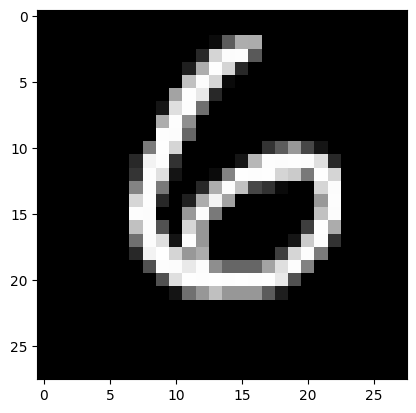

In [6]:
plt.imshow(images[0].permute(1, 2, 0), cmap="gray");

### **Build the Model**

The "Sampling" class will be created. This will be a custom layer that will provide the Gaussian noise input along with the mean (mu) and standard deviation (sigma) of the encoder output. In practice, the output of this layer is given by the equation:

$$z = \mu + e^{0.5\sigma} * \epsilon $$

where $\mu$ = mean, $\sigma$ = standard deviation and $\epsilon$ = random sample

In [7]:
class Sampling(nn.Module):
  def forward(self, mu, sigma):
    batch = mu.shape[0]
    dim = mu.shape[1]
    epsilon = torch.randn(batch, dim, device=device)
    z = mu + torch.exp(0.5 * sigma) * epsilon
    z = z.view(batch, dim, 1, 1)

    return z

**Encoder**

In [9]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()

    self.model_base = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=4, stride=2),
        nn.BatchNorm2d(16),
        nn.LeakyReLU(0.2),

        nn.Conv2d(16, 32, kernel_size=4, stride=2),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2),
    )

    self.mu = nn.Sequential(
        nn.Conv2d(32, z_dim, kernel_size=4, stride=2),
        nn.Flatten()
    )

    self.sigma = nn.Sequential(
        nn.Conv2d(32, z_dim, kernel_size=4, stride=2),
        nn.Flatten()
    )

    self.sampling = Sampling()

  def forward(self, x):
    x = self.model_base(x)
    mu = self.mu(x)
    sigma = self.sigma(x)
    z = self.sampling(mu, sigma)

    return mu, sigma, z

In [10]:
# Encoder architecture

encoder = Encoder().to(device)
print(summary(encoder, (1, 28, 28)))
del encoder

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             272
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]           8,224
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7              [-1, 2, 1, 1]           1,026
           Flatten-8                    [-1, 2]               0
            Conv2d-9              [-1, 2, 1, 1]           1,026
          Flatten-10                    [-1, 2]               0
         Sampling-11              [-1, 2, 1, 1]               0
Total params: 10,644
Trainable params: 10,644
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

**Decoder**

In [11]:
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.ConvTranspose2d(z_dim, 256, kernel_size=3, stride=2),
        nn.BatchNorm2d(256),
        nn.ReLU(),

        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.model(x)
    return x

In [12]:
# Decoder architecture

decoder = Decoder().to(device)
summary(decoder, (z_dim, 1, 1))
del decoder

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]           4,864
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
          Sigmoid-11            [-1, 1, 28, 28]               0
Total params: 604,993
Trainable params: 604,993
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

**VAE**

In [13]:
class VAE(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = Encoder()
    self.decoder = Decoder()

  def forward(self, x, train=True):
    mu, sigma, z = self.encoder(x)
    x = self.decoder(z)
    return mu, sigma, x

In [14]:
torch.manual_seed(123) #for the reproducibility

vae = VAE().to(device)
vae

VAE(
  (encoder): Encoder(
    (model_base): Sequential(
      (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.2)
    )
    (mu): Sequential(
      (0): Conv2d(32, 2, kernel_size=(4, 4), stride=(2, 2))
      (1): Flatten(start_dim=1, end_dim=-1)
    )
    (sigma): Sequential(
      (0): Conv2d(32, 2, kernel_size=(4, 4), stride=(2, 2))
      (1): Flatten(start_dim=1, end_dim=-1)
    )
    (sampling): Sampling()
  )
  (decoder): Decoder(
    (model): Sequential(
      (0): ConvTranspose2d(2, 256, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): ConvTranspose2d(

### **Train the Model**

**Utilities**

In [22]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [15]:
# Images directory
directory_images = "/content/drive/MyDrive/images"
directory_vae = os.path.join(directory_images, "vae_mnist")

os.makedirs(directory_vae, exist_ok=True)

In [16]:
# Display function

def show_and_save_images(real_images, fake_images, epoch, num_examples, nrow, save=True):

  real_images = real_images.cpu()
  fake_images = fake_images.cpu()

  real_images = make_grid(real_images[:num_examples], nrow).permute(1, 2, 0)
  fake_images = make_grid(fake_images[:num_examples], nrow).permute(1, 2, 0)

  fig, ax = plt.subplots(1, 2, figsize=(nrow*2, nrow*2))
  ax[0].imshow(real_images, cmap="gray")
  ax[0].axis("off")
  ax[0].set_title("Real Images")

  ax[1].imshow(fake_images, cmap="gray")
  ax[1].axis("off")
  ax[1].set_title("Generated Images")

  plt.show()

  # Save fake images
  if save:
    plt.imshow(fake_images, cmap="gray")
    plt.axis("off")
    plt.savefig(os.path.join(directory_vae, f"image{epoch:02d}.png"), transparent=True)
    plt.close()

**Generate random images to create the GIF**

In [17]:
torch.manual_seed(123) #for the reproducibility of noise tensor
num_examples = 25
nrow = 5

noise = torch.randn(num_examples, z_dim, 1, 1, device=device)
fake_images = vae.decoder(noise).detach().cpu()

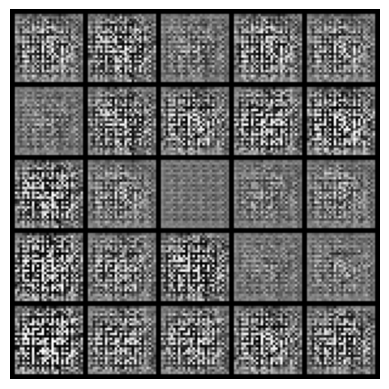

In [18]:
# Image of epoch 0

fake_images = make_grid(fake_images[:num_examples], nrow).permute(1, 2, 0)
plt.imshow(fake_images, cmap="gray")
plt.axis("off")
plt.savefig(os.path.join(directory_vae, f"image{0:02d}.png"), transparent=True);

**Kullback–Leibler Divergence**

To improve the generative capacity of the model, the random normal distribution introduced in the latent space must be taken into account. To do this, the [Kullback-Leibler Divergence](https://arxiv.org/abs/2002.07514) is calculated and will be added to the reconstruction loss. The formula is defined in the following function:

In [19]:
def kl_divergence_loss(mu, sigma):
  kl_loss = 1 + sigma - torch.square(mu) - torch.exp(sigma)
  kl_loss = -0.5 * torch.mean(kl_loss)

  return kl_loss

**Optimizer and Reconstruction Loss**

The multiplication factor of 784 in `recons_loss` adjusts the pixel reconstruction error to the total error per image in a VAE model trained with the MNIST dataset, where its images have dimensions (28, 28, 1), equivalent to 784 pixels.

In [20]:
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
recons_loss = nn.BCELoss()

**Training function**

In [21]:
def train_vae(epochs=epochs, num_examples=num_examples, nrow=nrow):
  history={"loss":[]}

  for epoch in range(epochs):
    loss_list = []

    with tqdm(train_dataset) as pbar:
      pbar.set_description(f"[Epoch: {epoch+1}/{epochs}]")
      for real_images, _ in pbar:
        real_images = real_images.to(device)

        optimizer.zero_grad()

        mu, sigma, recons_images = vae(real_images)
        loss = recons_loss(recons_images, real_images) * 784 + kl_divergence_loss(mu, sigma)

        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())
        pbar.set_postfix({"loss": loss.item()})

    loss_mean = np.mean(loss_list)
    history["loss"].append(loss_mean)

    display.clear_output(wait=False)
    print(f"Epoch {epoch+1}, Loss: {loss_mean}")

    # Examples for training and GIF
    fake_images = vae.decoder(noise).detach()
    show_and_save_images(real_images, fake_images, epoch+1, num_examples, nrow)

  return history

Epoch 25, Loss: 151.2501978437021


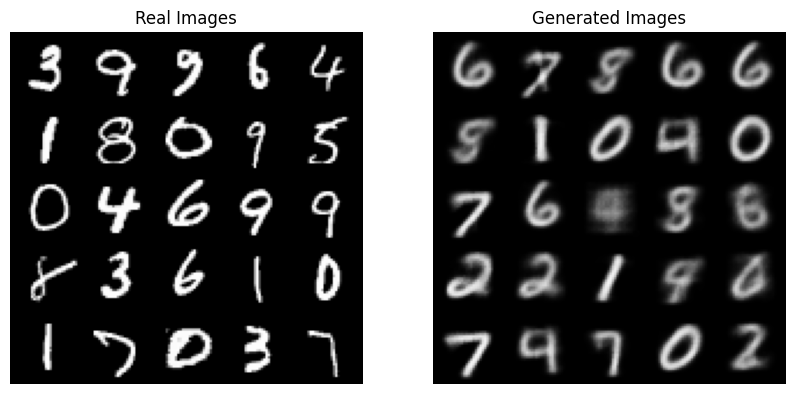

In [22]:
history = train_vae()

In [23]:
# Function to plot the losses
def plot_metrics(history, renderer=None, epochs = epochs):
  losses = history["loss"]
  list_epochs=np.arange(1, epochs+1)

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=losses, name="Loss", line=dict(color="blue", width=2)))
  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text="Loss")
  fig.update_layout(title=f"<b>Evolution of Loss across Epochs</b>",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

In [24]:
# Interactive graphic
plot_metrics(history)

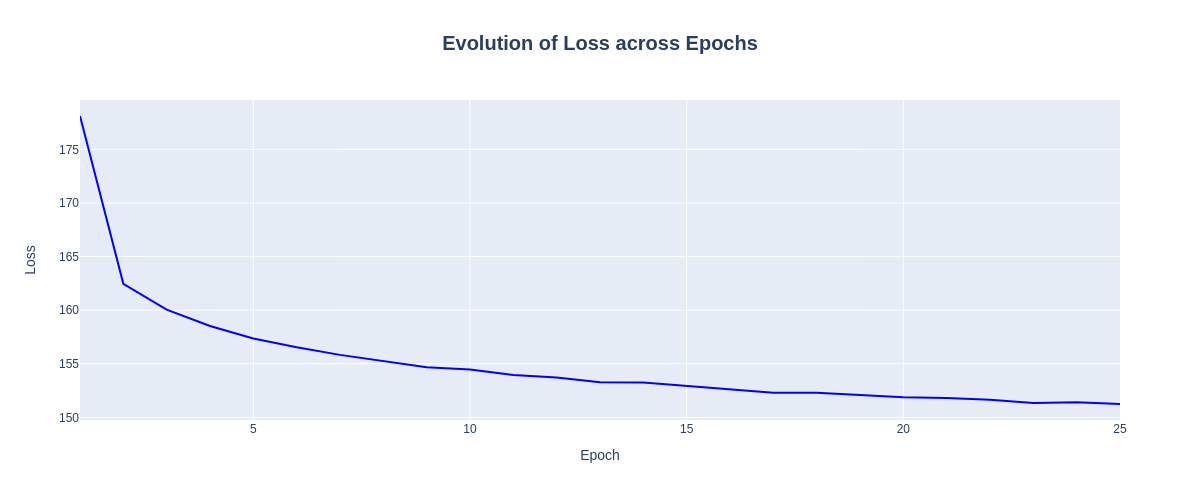

In [25]:
# Image for GitHub
plot_metrics(history, renderer="png")

### **Create a GIF from the generated images**

In [26]:
!pip install tensorflow_docs -q

import tensorflow_docs.vis.embed as embed

In [27]:
# Function to create gifs

def create_gif(gif_file, images_file, fps=1):
  with imageio.get_writer(gif_file, mode="I", loop=0, fps=fps) as writer:
    filenames = sorted(glob.glob(f"{images_file}/*.png"))
    for filename in filenames:
      image = imageio.imread(filename)
      writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


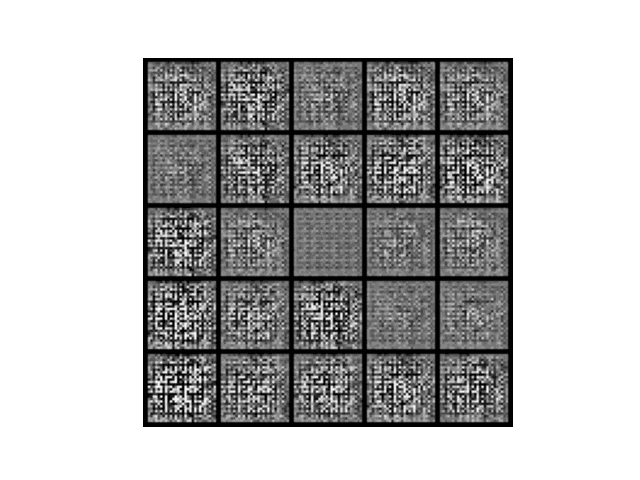

In [28]:
gif_file = os.path.join(directory_vae, "mnist_vae.gif")
create_gif(gif_file, directory_vae, fps=2)
embed.embed_file(gif_file)

### **Generated Examples**

**Generating digits with random noise**

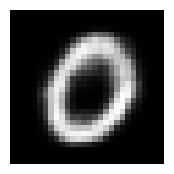

In [29]:
noise = torch.randn(1, z_dim, 1, 1, device=device)
generated_example = vae.decoder(noise)[0].detach().cpu()
plt.figure(figsize=(2, 2))
plt.imshow(generated_example.permute(1, 2, 0), cmap="gray")
plt.axis("off");

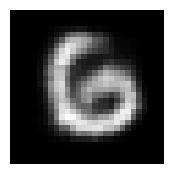

In [34]:
noise = torch.randn(1, z_dim, 1, 1, device=device)
generated_example = vae.decoder(noise)[0].detach().cpu()
plt.figure(figsize=(2, 2))
plt.imshow(generated_example.permute(1, 2, 0), cmap="gray")
plt.axis("off");

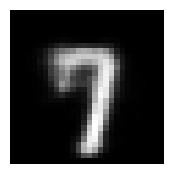

In [32]:
noise = torch.randn(1, z_dim, 1, 1, device=device)
generated_example = vae.decoder(noise)[0].detach().cpu()
plt.figure(figsize=(2, 2))
plt.imshow(generated_example.permute(1, 2, 0), cmap="gray")
plt.axis("off");